Data shape after loading: (34527, 24)
Data types statistics after loading:
int64      9
float64    8
object     7
Name: count, dtype: int64
Object dtype columns after loading:
['Locality', 'Type of Property', 'Subtype of Property', 'Type of Sale', 'PEB', 'State of the Building', 'Url']
Index(['Unnamed: 0', 'Locality', 'Zip Code', 'Type of Property',
       'Subtype of Property', 'Price', 'Type of Sale', 'Number of Rooms',
       'Livable Space (m2)', 'Fully Equipped Kitchen', 'Furnished',
       'Fireplace', 'Terrace', 'Terrace Area (m2)', 'Garden',
       'Garden Area (m2)', 'Swimming Pool', 'Surface of the Land (m2)',
       'Number of Facades', 'Construction Year', 'PEB',
       'Primary Energy Consumption (kWh/m2)', 'State of the Building', 'Url'],
      dtype='object')
Geo Data shape after loading: (1231, 26)
Geo Data types statistics:
object     20
float64     4
int64       2
Name: count, dtype: int64
Fiscal Data shape after loading: (639, 2)
Fiscal Data types statistics:
int64  

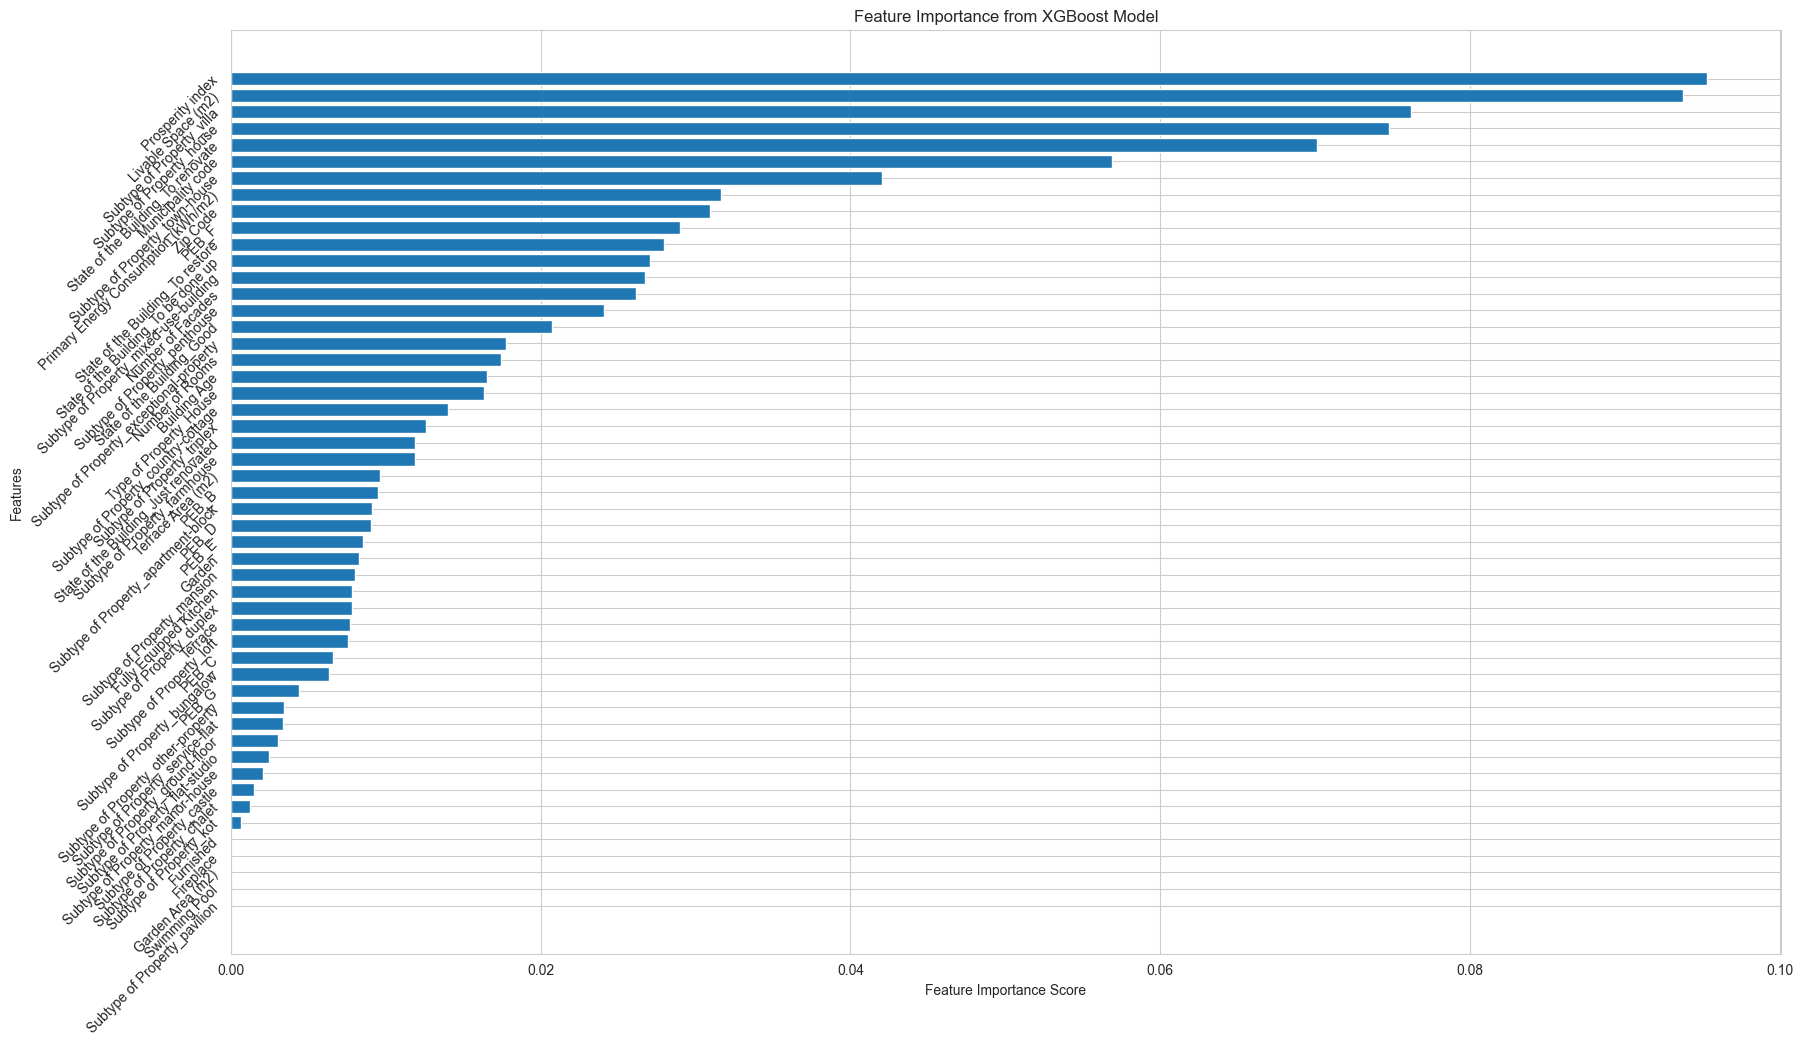

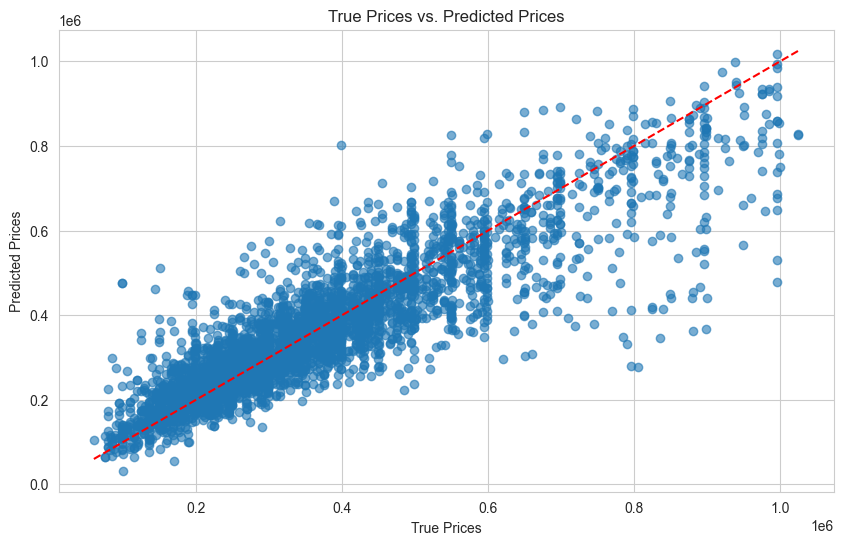

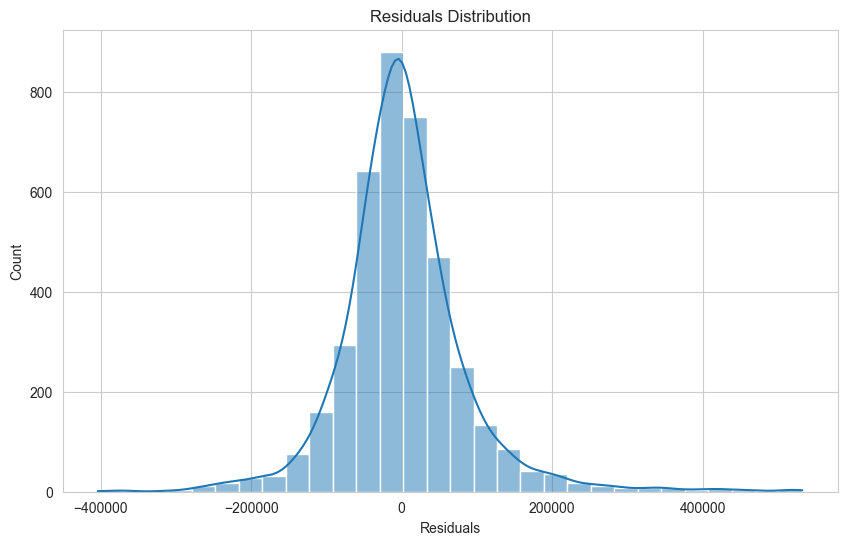

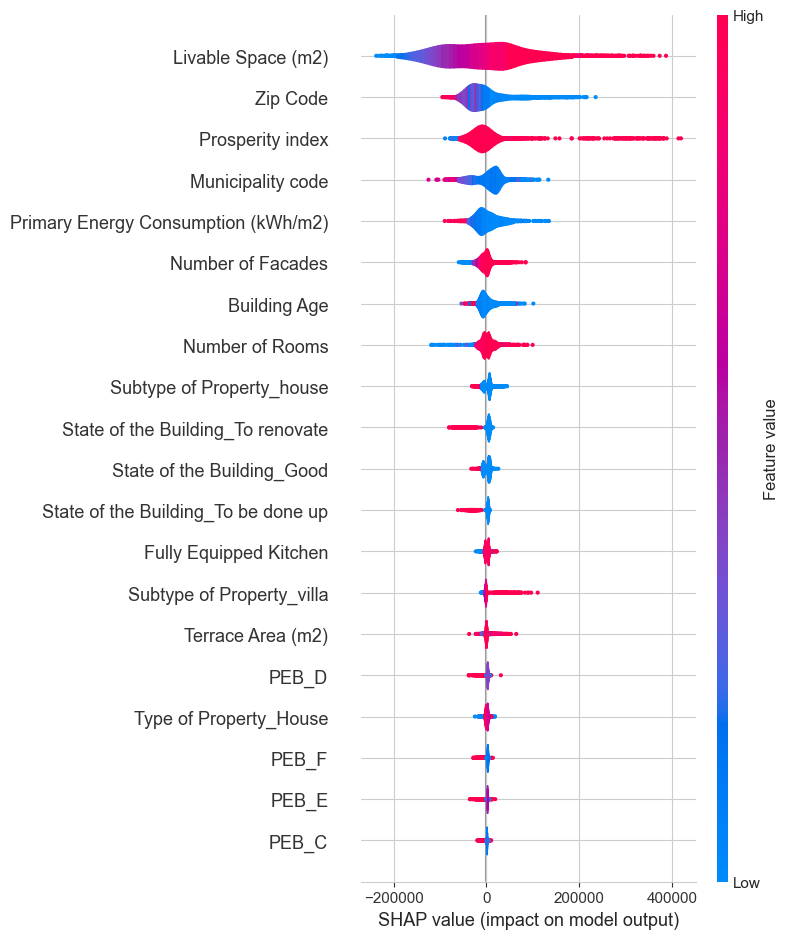

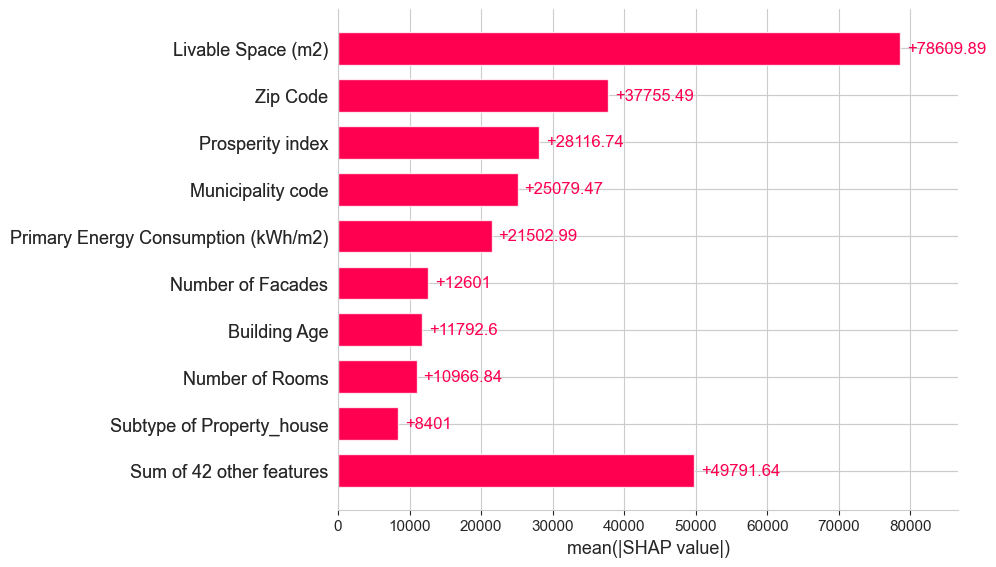

<Figure size 2000x1000 with 0 Axes>

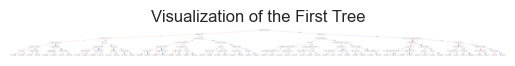

Model Metrics:
MAE (Train): 38897.85688496798
RMSE (Train): 54770.832116882564
R^2 (Train): 0.9058487128719253
MAPE (Train): 12.321359119890856
sMAPE (Train): 5.837640753793139
MAE (Test): 57035.56422946227
RMSE (Test): 84263.23516885847
R^2 (Test): 0.7789307691931685
MAPE (Test): 17.345657316476657
sMAPE (Test): 8.148073402065554


<Figure size 640x480 with 0 Axes>

In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.impute import KNNImputer
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import time
from scipy import stats
import graphviz


class DataPreprocessor:
    def __init__(self, file_path: str, geo_data_path: str, fiscal_data_path: str):
        """
        Initializes the DataPreprocessor with file paths for the main data, geographical data, and fiscal data.

        Args:
            file_path (str): Path to the main dataset CSV file.
            geo_data_path (str): Path to the geographical data CSV file.
            fiscal_data_path (str): Path to the fiscal data Excel file.
        """
        self.file_path = file_path
        self.data = None
        self.geo_data_path = geo_data_path
        self.geo_data = None
        self.fiscal_data_path = fiscal_data_path
        self.fiscal_data = None

        # Column categories
        self.important_columns = [
            "Price",
            "Type of Property",
            "Livable Space (m2)",
            "Number of Rooms",
        ]
        self.one_hot_columns = [
            "PEB",
            "State of the " "Building",
            "Type " "of " "Property",
            "Subtype of Property",
        ]
        self.drop_columns = ["Locality", "Url", "Surface of the Land (m2)"]
        self.default_to_zero_columns = ["Terrace Area (m2)", "Garden Area (m2)"]
        self.num_impute_columns = [
            "Building Age",
            "Number of Facades",
            "Primary Energy Consumption (kWh/m2)",
        ]
        self.cat_impute_columns = ["State of the Building", "PEB"]
        self.normalize_columns = [
            "Livable Space (m2)",
            "Number of Facades",
            "Number of Rooms",
            "Building Age",
            "Primary Energy Consumption (kWh/m2)",
            "Terrace Area (m2)",
            "Garden Area (m2)",
        ]

    def load_data(self) -> pd.DataFrame:
        """
        Loads the main dataset from CSV.

        Returns:
            pd.DataFrame: Loaded dataset.
        """
        self.data = pd.read_csv(self.file_path)
        print("Data shape after loading:", self.data.shape)
        print("Data types statistics after loading:")
        print(self.data.dtypes.value_counts())

        print("Object dtype columns after loading:")
        print(self.data.select_dtypes(include=["object"]).columns.tolist())
        print(self.data.columns)
        return self.data

    def load_geo_data(self) -> pd.DataFrame:
        """
        Loads the geographical data from CSV.

        Returns:
            pd.DataFrame: Loaded geographical dataset.
        """
        self.geo_data = pd.read_csv(self.geo_data_path, sep=";")
        print("Geo Data shape after loading:", self.geo_data.shape)
        print("Geo Data types statistics:")
        print(self.geo_data.dtypes.value_counts())
        return self.geo_data

    def load_fiscal_data(self) -> pd.DataFrame:
        """
        Loads the fiscal data from Excel, specifically the 'Totaal' sheet.

        Returns:
            pd.DataFrame: Loaded fiscal dataset.
        """
        self.fiscal_data = pd.read_excel(self.fiscal_data_path)
        print("Fiscal Data shape after loading:", self.fiscal_data.shape)
        print("Fiscal Data types statistics:")
        print(self.fiscal_data.dtypes.value_counts())
        return self.fiscal_data

    def merge_data(self) -> None:
        """
        Merges the main dataset with geographical and fiscal data based on specified keys.
        """
        if "Zip Code" in self.data.columns and ("Post code") in self.geo_data.columns:
            self.data = self.data.merge(
                self.geo_data[["Post code", "Municipality code"]],
                left_on="Zip Code",
                right_on="Post code",
                how="left",
            )

        # Merge with fiscal data based on municipality code
        if (
            "Municipality code" in self.data.columns
            and "NIS code" in self.fiscal_data.columns
        ):
            self.data = self.data.merge(
                self.fiscal_data[["NIS code", "Prosperity index"]],
                left_on="Municipality code",
                right_on="NIS code",
                how="left",
            )

        # Drop duplicated columns
        if "Post code" in self.data.columns:
            self.data.drop("Post code", axis=1, inplace=True)

        if "NIS code" in self.data.columns:
            self.data.drop("NIS code", axis=1, inplace=True)

        self.data.dropna(subset=["Prosperity index", "Municipality code"], inplace=True)

        print("Data shape after merging with geo data:", self.data.shape)

        print("Data shape after merging with fiscal data:", self.data.shape)

    def preprocess(self) -> pd.DataFrame:
        """
        Executes all preprocessing steps including loading data, converting types, handling missing values,
        and merging datasets.

        Returns:
            pd.DataFrame: The preprocessed dataset.
        """

        # Load geo data and fiscal data
        self.load_geo_data()
        self.load_fiscal_data()

        # Redundant columns (drop)
        self._drop_unnecessary_columns()
        print("Data shape after dropping unnecessary columns:", self.data.shape)
        print("Data types statistics after dropping unnecessary columns:")
        print(self.data.dtypes.value_counts())
        print("Object dtype columns after dropping unnecessary columns:")
        print(self.data.select_dtypes(include=["object"]).columns.tolist())

        # Check for empty values in important columns -
        # remove those rows
        self.data.dropna(subset=self.important_columns, inplace=True)
        print(
            "Data shape after removing rows with missing important columns:",
            self.data.shape,
        )
        print(
            "Data types statistics after removing rows with missing important columns:"
        )
        print(self.data.dtypes.value_counts())
        print(
            "Object dtype columns after removing rows with missing important columns:"
        )
        print(self.data.select_dtypes(include=["object"]).columns.tolist())

        # Empty values - default to 0
        for column in self.default_to_zero_columns:
            if column in self.data.columns:
                self.data[column] = self.data[column].fillna(0)
        print(
            "Data shape after defaulting specified columns to 0 for missing values:",
            self.data.shape,
        )
        print("Data types statistics after defaulting specified columns to 0:")
        print(self.data.dtypes.value_counts())
        print("Object dtype columns after defaulting missing values to 0:")
        print(self.data.select_dtypes(include=["object"]).columns.tolist())

        # Remove specified drop columns
        self.data.drop(columns=self.drop_columns, inplace=True, errors="ignore")
        print("Data shape after dropping specified columns:", self.data.shape)
        print("Data types statistics after dropping specified columns:")
        print(self.data.dtypes.value_counts())
        print("Object dtype columns after dropping specified columns:")
        print(self.data.select_dtypes(include=["object"]).columns.tolist())

        # Calculate age of the building, add new Age
        # column &
        # drop the
        # Constr.Year column
        self.calculate_building_age()

        if "Construction Year" in self.data.columns:
            self.data.drop("Construction Year", axis=1, inplace=True)

        # KNN Imputation for specified numeric columns
        imputer = KNNImputer()
        self.data[self.num_impute_columns] = imputer.fit_transform(
            self.data[self.num_impute_columns]
        )

        print("Data shape after KNN imputation for specified columns:", self.data.shape)
        print("Data types statistics after KNN imputation:")
        print(self.data.dtypes.value_counts())

        # Count of missing values per row
        print("Missing values before filtering:")
        print(self.data.isnull().sum())

        missing_values_count = self.data.isnull().sum(axis=1)
        print("Count of missing values per row before dropping:")
        print(missing_values_count.value_counts())

        # Remove rows with 11 or more missing values
        self.data.dropna(thresh=10, inplace=True)
        print(
            "Data shape after removing rows with 11 or more missing values:",
            self.data.shape,
        )
        print(
            "Data types statistics after removing rows with 11 or more missing values:"
        )
        print(self.data.dtypes.value_counts())
        print(
            "Object dtype columns after removing rows with 11 or more missing values:"
        )
        print(self.data.select_dtypes(include=["object"]).columns.tolist())

        # Remove outliers
        self._remove_outliers()
        print("Data shape after removing outliers:", self.data.shape)
        print("Data types statistics after removing outliers:")
        print(self.data.dtypes.value_counts())
        print("Object dtype columns after removing outliers:")
        print(self.data.select_dtypes(include=["object"]).columns.tolist())

        # One-hot encode specified columns
        self.data = pd.get_dummies(
            self.data, columns=self.one_hot_columns, drop_first=True
        )
        print("Data shape after one-hot encoding:", self.data.shape)
        print("Data types statistics after one-hot encoding:")
        print(self.data.dtypes.value_counts())

        # Convert all to numeric
        self._convert_to_numeric()
        print("Data shape after converting to numeric:", self.data.shape)
        print("Data types statistics after converting to numeric:")
        print(self.data.dtypes.value_counts())
        print("Object dtype columns after converting to numeric:")
        print(self.data.select_dtypes(include=["object"]).columns.tolist())

        self.merge_data()

        self.normalize_numeric_data()

        return self.data

    def _drop_unnecessary_columns(self) -> None:
        """
        Drops columns from the DataFrame if they have only one unique value
        or if all values are identical, as these do not provide useful information for modeling.
        """
        for column in self.data.columns:
            unique_values = self.data[column].nunique()
            if unique_values == 1 or unique_values == len(self.data):
                self.data.drop(column, axis=1, inplace=True)

    def calculate_building_age(self) -> None:
        """
        Calculates the age of buildings based on the 'Construction Year' column.
        If the construction year is missing, the age is set to NaN.
        """
        current_year = 2024
        self.data["Building Age"] = np.where(
            self.data["Construction Year"].isnull(),
            np.nan,
            current_year - self.data["Construction Year"],
        )
        print("Building age calculated. Future years result in negative ages.")

    def _convert_to_numeric(self) -> None:
        """
        Converts all suitable columns in the DataFrame to numeric types.
        Boolean columns are converted to integers (0 and 1).
        """
        for column in self.data.columns:
            try:
                self.data[column] = pd.to_numeric(self.data[column])
            except ValueError:
                continue

        for column in self.data.columns:
            if self.data[column].dtype == "bool":
                self.data[column] = self.data[column].astype(int)
            print("Data types after converting booleans to numeric:")
            print(self.data.dtypes.value_counts())

    def _remove_outliers(self) -> None:
        """
        Removes outliers from the DataFrame based on the Interquartile Range (IQR) method.
        Rows containing outliers in any numeric column are removed.

        Outliers are defined as values that fall below Q1 - 1.5 * IQR or above Q3 + 1.5 * IQR.
        """
        # Select only numeric columns for outlier removal
        numeric_data = self.data.select_dtypes(include=["float64", "int64"])

        Q1 = numeric_data.quantile(0.25)
        Q3 = numeric_data.quantile(0.75)
        IQR = Q3 - Q1

        # Define a condition to filter out outliers
        # Use .any(axis=1) to keep rows where at least one column is an outlier
        condition = ~(
            (numeric_data < (Q1 - 1.5 * IQR)) | (numeric_data > (Q3 + 1.5 * IQR))
        ).any(axis=1)

        # Update the DataFrame to keep only non-outlier rows
        self.data = self.data[condition]

    def normalize_numeric_data(self) -> None:
        """
        Normalizes specified numeric columns in the DataFrame to a range of [0, 1].

        Applies Min-Max normalization to the columns defined in self.normalize_columns.
        """
        for col in self.data.columns:
            # Apply Min-Max normalization
            self.data[self.normalize_columns] = self.data[self.normalize_columns].apply(
                lambda x: (x - x.min()) / (x.max() - x.min())
            )
        print("Data normalization completed.")
        print(self.data.isnull().sum().sort_values(ascending=False))


class XGBoostModel:
    def __init__(self):
        """
        Initializes the XGBoostModel with an uninitialized model and dataset placeholder.
        """
        self.model = None
        self.X = None

    def train(self, X_train: pd.DataFrame, y_train: pd.Series) -> None:
        """
        Trains the XGBoost regression model on the provided training data.

        Args:
            X_train (pd.DataFrame): The input features for training.
            y_train (pd.Series): The target variable (output) for training.
        """
        start_time = time.time()
        self.X = X_train
        self.model = xgb.XGBRegressor(objective="reg:squarederror")
        self.model.fit(X_train, y_train)
        end_time = time.time()

        training_time = end_time - start_time
        print(f"Model training completed in " f"{training_time:.4f} seconds.")

    def predict(self, X: pd.DataFrame) -> np.ndarray:
        """
        Makes predictions using the trained XGBoost model.

        Args:
            X (pd.DataFrame): The input features for making predictions.

        Returns:
            np.ndarray: The predicted values.
        """
        start_time = time.time()  # Start time for prediction
        predictions = self.model.predict(X)
        end_time = time.time()  # End time for prediction

        inference_time = end_time - start_time
        print(f"Inference completed in {inference_time:.4f} seconds.")

        return predictions

    def get_feature_importance(self, feature_names: list) -> dict:
        """
        Retrieves the feature importance from the XGBoost model.

        Args:
            feature_names (list): A list of feature names corresponding to the model features.

        Returns:
            Dict[str, float]: A dictionary mapping each feature name to its importance score.
        """
        importance = self.model.feature_importances_
        feature_importance = dict(zip(feature_names, importance))
        return feature_importance


class ModelEvaluator:
    def __init__(
        self,
        y_train: pd.Series,
        y_train_pred: np.ndarray,
        y_test: pd.Series,
        y_test_pred: np.ndarray,
        model,
        X_test: pd.DataFrame,
    ):
        """
        Initializes the ModelEvaluator with predictions and true values.

        Args:
            y_train (pd.Series): The true values for the training dataset.
            y_train_pred (np.ndarray): The predicted values for the training dataset.
            y_test (pd.Series): The true values for the testing dataset.
            y_test_pred (np.ndarray): The predicted values for the testing dataset.
            model (Any): The trained model instance from which to retrieve feature importance.
            X_test (pd.DataFrame): The features used for testing predictions.
        """
        self.y_train = y_train
        self.y_train_pred = y_train_pred
        self.y_test = y_test
        self.y_test_pred = y_test_pred
        self.model = model
        self.X_test = X_test

    def calculate_metrics(self) -> dict:
        """
        Calculates and returns various evaluation metrics for the model.

        Returns:
            Dict[str, Any]: A dictionary containing metrics for both original and retrained models.
        """
        metrics = {}

        # Ensure predictions and true values are numeric
        self.y_train = self.y_train.astype(float)
        self.y_train_pred = self.y_train_pred.astype(float)
        self.y_test = self.y_test.astype(float)
        self.y_test_pred = self.y_test_pred.astype(float)

        # Training metrics
        metrics["MAE_train"] = mean_absolute_error(self.y_train, self.y_train_pred)
        metrics["RMSE_train"] = np.sqrt(
            mean_squared_error(self.y_train, self.y_train_pred)
        )
        metrics["R2_train"] = r2_score(self.y_train, self.y_train_pred)
        metrics["MAPE_train"] = (
            np.mean(np.abs((self.y_train - self.y_train_pred) / self.y_train)) * 100
            if np.mean(self.y_train) != 0
            else np.nan
        )
        metrics["sMAPE_train"] = np.mean(
            np.abs(self.y_train - self.y_train_pred)
            / (np.abs(self.y_train) + np.abs(self.y_train_pred))
            * 100
        )

        # Testing metrics
        metrics["MAE_test"] = mean_absolute_error(self.y_test, self.y_test_pred)
        metrics["RMSE_test"] = np.sqrt(
            mean_squared_error(self.y_test, self.y_test_pred)
        )
        metrics["R2_test"] = r2_score(self.y_test, self.y_test_pred)
        metrics["MAPE_test"] = (
            np.mean(np.abs((self.y_test - self.y_test_pred) / self.y_test)) * 100
            if np.mean(self.y_test) != 0
            else np.nan
        )
        metrics["sMAPE_test"] = np.mean(
            np.abs(self.y_test - self.y_test_pred)
            / (np.abs(self.y_test) + np.abs(self.y_test_pred))
            * 100
        )

        # Get feature importance
        feature_importance = self.model.get_feature_importance(
            self.model.model.get_booster().feature_names
        )

        # Plot feature importance and results
        self.plot_feature_importance(feature_importance)
        self.plot_results()
        self.plot_shap_sum()
        self.plot_model_tree()

        return metrics

    def plot_feature_importance(self, feature_importance):
        # Ensure feature importance is numeric
        if not isinstance(feature_importance, dict):
            print("Feature importance should be a dictionary.")
            return

        # Sort features by importance
        sorted_importance = sorted(
            feature_importance.items(), key=lambda x: x[1], reverse=True
        )
        features, importance = zip(*sorted_importance)

        # Convert importance values to float
        importance = [float(i) for i in importance]

        plt.figure(figsize=(20, 12))
        plt.barh(features, importance)
        plt.xlabel("Feature Importance Score")
        plt.ylabel("Features")
        plt.yticks(rotation=45)
        plt.title("Feature Importance from XGBoost Model")
        plt.gca().invert_yaxis()  # To display the most important feature at the top
        plt.show()

    def plot_results(self):
        plt.figure(figsize=(10, 6))
        plt.scatter(self.y_test, self.y_test_pred, alpha=0.6)
        plt.plot(
            [min(self.y_test), max(self.y_test)],
            [min(self.y_test), max(self.y_test)],
            color="red",
            linestyle="dashed",
        )
        plt.title("True Prices vs. Predicted Prices")
        plt.xlabel("True Prices")
        plt.ylabel("Predicted Prices")
        plt.grid(True)
        plt.show()

        plt.figure(figsize=(10, 6))
        sns.histplot(self.y_test - self.y_test_pred, bins=30, kde=True)
        plt.title("Residuals Distribution")
        plt.xlabel("Residuals")
        plt.grid(True)
        plt.show()

    def plot_model_tree(self):
        # Plotting the first tree in the XGBoost model
        plt.figure(figsize=(20, 10))
        xgb.plot_tree(self.model.model, num_trees=0, fontsize=10)
        plt.title("Visualization of the First Tree")
        plt.show()

        plt.savefig("xgboost_tree.png")

        xgb.to_graphviz(self.model.model, num_trees=0, rankdir="LR").render(
            "xgboost_tree", format="png", cleanup=True
        )

    def plot_shap_sum(self):
        # SHAP values
        explainer = shap.Explainer(self.model.model)
        shap_values = explainer(self.X_test)

        # SHAP summary plot
        plt.figure(figsize=(12, 10))
        shap.summary_plot(shap_values, self.X_test, plot_type="violin")

        shap.plots.bar(shap_values)


def main():
    file_path = "scraping_results.csv"
    geo_data_path = "georef-belgium-postal-codes@public.csv"
    fiscal_data_path = "prosperity_belgium.xlsx"
    data_preprocessor = DataPreprocessor(file_path, geo_data_path, fiscal_data_path)
    processed_data = data_preprocessor.load_data()
    processed_data = data_preprocessor.preprocess()

    print(processed_data.columns)

    # Split data into features and target
    X = processed_data.drop("Price", axis=1)
    y = processed_data["Price"]

    # Convert features to numeric, coercing errors to NaN
    X = X.apply(pd.to_numeric, errors="coerce")
    X.fillna(0, inplace=True)

    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    # Train XGBoost model
    xgb_model = XGBoostModel()
    xgb_model.train(X_train, y_train)

    # Make predictions on training and test datasets
    y_train_pred = xgb_model.predict(X_train)
    y_test_pred = xgb_model.predict(X_test)

    # Evaluate the model
    evaluator = ModelEvaluator(
        y_train, y_train_pred, y_test, y_test_pred, xgb_model, X_test
    )
    metrics = evaluator.calculate_metrics()

    # Print evaluation metrics
    print("Model Metrics:")
    print(f'MAE (Train): {metrics["MAE_train"]}')
    print(f'RMSE (Train): {metrics["RMSE_train"]}')
    print(f'R^2 (Train): {metrics["R2_train"]}')
    print(f'MAPE (Train): {metrics["MAPE_train"]}')
    print(f'sMAPE (Train): {metrics["sMAPE_train"]}')
    print(f'MAE (Test): {metrics["MAE_test"]}')
    print(f'RMSE (Test): {metrics["RMSE_test"]}')
    print(f'R^2 (Test): {metrics["R2_test"]}')
    print(f'MAPE (Test): {metrics["MAPE_test"]}')
    print(f'sMAPE (Test): {metrics["sMAPE_test"]}')


if __name__ == "__main__":
    main()
